## PreProcessing Step
### the following issues need to be handled
1. some images are inverted (white is used for font and black for background unlike the majority)
2. light differs (you need to binarize and enhance the image quality)



In [86]:
from preprocessing import *
from feature_extraction import extract_hog_features, horizontalProfileProjection
import torch
from torch import nn, optim
from nn_utils import nn_train, nn_predict, nn_accuracy

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
classes = ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']

In [39]:
X, Y = load_data()
print(X.shape)
print(Y.shape)

(1684,)
(1684,)


(101, 280)
The ground-truth value of this image is:  kufi


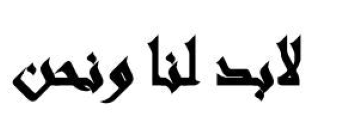

In [6]:
random_index = np.random.randint(0, 1683)

# Plot the image.
print(X[random_index].shape)
plt.imshow(X[random_index], 'gray')
plt.axis("off")

print("The ground-truth value of this image is: ",
      classes[Y[random_index]-1])

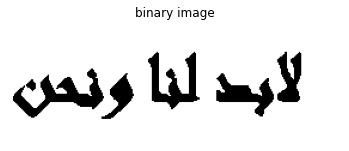

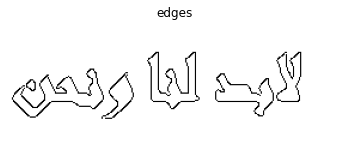

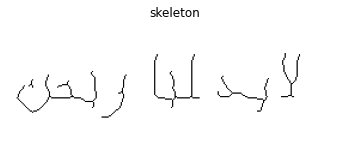

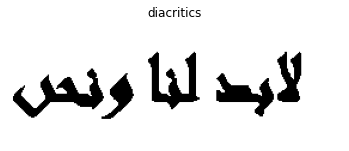

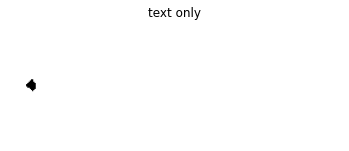

In [7]:
binaryImage = binraization(X[random_index])
edges, skeleton, textOnly, diacritics = extractImagesSet(binaryImage//255)

plt.imshow(binaryImage, 'gray')
plt.title('binary image')
plt.axis("off")
plt.show()


plt.imshow(edges, 'gray')
plt.title('edges')
plt.axis("off")
plt.show()

plt.imshow(skeleton, 'gray')
plt.title('skeleton')
plt.axis("off")
plt.show()

plt.imshow(diacritics, 'gray')
plt.title('diacritics')
plt.axis("off")
plt.show()

plt.imshow(textOnly, 'gray')
plt.title('text only')
plt.axis("off")
plt.show()

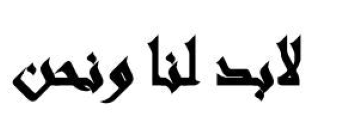

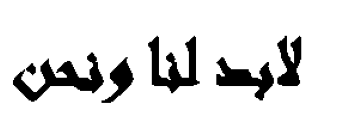

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01388889
 0.07222222 0.11944444 0.18333333 0.19166667 0.16388889 0.15
 0.14444444 0.18333333 0.23333333 0.26388889 0.30833333 0.37222222
 0.44722222 0.56666667 0.65555556 0.675      0.72222222 0.95
 1.         0.98611111 0.64444444 0.32777778 0.25277778 0.19444444
 0.15833333 0.125      0.08611111 0.02222222 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [89]:
img = X[random_index].copy()

plt.imshow(img, 'gray')
plt.axis("off")
plt.show()

binaryImage = binraization(img)
plt.imshow(binaryImage, 'gray')
plt.axis("off")
plt.show()

print(horizontalProfileProjection(binaryImage, 50))

In [6]:
# features, labels = [], []

# for i in range(X.shape[0]):
#     X[i] = binraization(X[i])
# #     Xi_textOnly, _ = diacriticsSegmentationClustering(X[i]//255)
#     features.append(extract_hog_features(X[i]))
# #     features.append(extract_hog_features(Xi_textOnly*255))
# #     labels.append(Y[i])
# #     labels.append(Y[i])

# features = np.asarray(features)
# # labels = np.asarray(labels)
# print(features.shape)
# # print(labels.shape)

In [40]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(X, Y)

In [41]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

features, labels = [], []

for i in range(X_train.shape[0]):
    X_train[i] = binraization(X_train[i])
    Xi_textOnly, _ = diacriticsSegmentationClustering(X_train[i]//255)
    features.append(extract_hog_features(X_train[i]))
    features.append(extract_hog_features(Xi_textOnly*255))
    labels.append(Y_train[i])
    labels.append(Y_train[i])

features = np.asarray(features)
labels = np.asarray(labels)

features_valid, labels_valid = [], []

for i in range(X_valid.shape[0]):
    X_valid[i] = binraization(X_valid[i])
    Xi_textOnly, _ = diacriticsSegmentationClustering(X_valid[i]//255)
    features_valid.append(extract_hog_features(X_valid[i]))
    features_valid.append(extract_hog_features(Xi_textOnly*255))
    labels_valid.append(Y_valid[i])
    labels_valid.append(Y_valid[i])


features_valid = np.asarray(features_valid)
labels_valid = np.asarray(labels_valid)
    
features_test, labels_test = [], []

for i in range(X_test.shape[0]):
    X_test[i] = binraization(X_test[i])
    Xi_textOnly, _ = diacriticsSegmentationClustering(X_test[i]//255)
    features_test.append(extract_hog_features(X_test[i]))
    features_test.append(extract_hog_features(Xi_textOnly*255))
    labels_test.append(Y_test[i])
    labels_test.append(Y_test[i])

features_test = np.asarray(features_test)
labels_test = np.asarray(labels_test)

print(features.shape, labels.shape)
print(features_valid.shape, labels_valid.shape)
print(features_test.shape, labels_test.shape)

(1010,) (1010,)
(337,) (337,)
(337,) (337,)
(2020, 756) (2020,)
(674, 756) (674,)
(674, 756) (674,)


In [42]:
X_train = torch.from_numpy(features)
print(X_train.shape)
Y_train = torch.from_numpy(labels)
print(Y_train.shape)
X_valid = torch.from_numpy(features_valid)
print(X_valid.shape)
Y_valid = torch.from_numpy(labels_valid)
print(Y_valid.shape)
X_test = torch.from_numpy(features_test)
print(X_test.shape)
Y_test = torch.from_numpy(labels_test)
print(Y_test.shape)

torch.Size([2020, 756])
torch.Size([2020])
torch.Size([674, 756])
torch.Size([674])
torch.Size([674, 756])
torch.Size([674])


In [48]:
X_train.double().dtype

torch.float64

Epoch: 1/200 Training Loss: 0.0011354331923003245 validation Loss: 0.0030254302463474897 Test Loss: 0.0029849433049957547
Epoch: 11/200 Training Loss: 0.00048703282776445446 validation Loss: 0.0013518828666528539 Test Loss: 0.0012565265777203026
Epoch: 21/200 Training Loss: 0.00027408292978116784 validation Loss: 0.0008159874101067155 Test Loss: 0.0007513136290654938
Epoch: 31/200 Training Loss: 0.0001838873518575536 validation Loss: 0.0006212614675657686 Test Loss: 0.0005513914703261604
Epoch: 41/200 Training Loss: 0.00013823965103319376 validation Loss: 0.000530561106141314 Test Loss: 0.0004895002711066861
Epoch: 51/200 Training Loss: 0.00010092161079444507 validation Loss: 0.0005159270604215673 Test Loss: 0.0004809719430232968
Epoch: 61/200 Training Loss: 7.455180039500246e-05 validation Loss: 0.0004951119511346788 Test Loss: 0.00046089525923177115
Epoch: 71/200 Training Loss: 5.175236723210552e-05 validation Loss: 0.0004712986132511399 Test Loss: 0.0004498858657010585
Epoch: 81/200

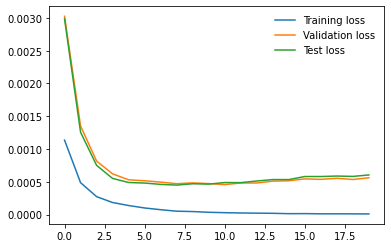

training accuracy = 100.0%
validation accuracy = 89.76261127596439%
test accuracy = 89.91097922848664%


In [49]:
from nn_utils import *

model = nn.Sequential(nn.Linear(756, 256),
                    nn.ReLU(),
                    nn.Dropout(0.6),
#                     nn.Linear(512, 256),
#                     nn.ReLU(),
#                     nn.Dropout(0.5),
                    nn.Linear(256, 10),
                    nn.LogSoftmax(dim=1))

train_losses, validation_losses, test_losses =\
    nn_train(model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, epochs=200, lr=0.01)

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.show()

train_predictions = nn_predict(model, X_train)
validation_predictions = nn_predict(model, X_valid)
test_predictions = nn_predict(model, X_test)

print(f'training accuracy = {nn_accuracy(train_predictions, Y_train) * 100}%')
print(f'validation accuracy = {nn_accuracy(validation_predictions, Y_valid) * 100}%')
print(f'test accuracy = {nn_accuracy(test_predictions, Y_test) * 100}%')

In [30]:
from sklearn import svm, metrics

poly = svm.SVC(kernel = 'poly', C=1, degree=4, decision_function_shape='ovo').fit(X_train, Y_train)

train_predictions = poly.predict(X_train)
validation_predictions = poly.predict(X_valid)
test_predictions = poly.predict(X_test)

print(f'training accuracy = {metrics.accuracy_score(Y_train, train_predictions) * 100}%')
print(f'validation accuracy = {metrics.accuracy_score(Y_valid, validation_predictions) * 100}%')
print(f'test accuracy = {metrics.accuracy_score(Y_test, test_predictions) * 100}%')

training accuracy = 100.0%
validation accuracy = 90.0593471810089%
test accuracy = 91.24629080118694%
